In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("ashishmotwani/tomato")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/tomato


In [ ]:
import warnings
warnings.filterwarnings('ignore')

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.metrics import classification_report , confusion_matrix , accuracy_score , auc
from sklearn.model_selection import train_test_split

import cv2
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Input, Dense,Conv2D , MaxPooling2D, Flatten,BatchNormalization,Dropout
from tensorflow.keras.preprocessing import image_dataset_from_directory
import tensorflow_hub as hub

In [ ]:
labels = {'Bacterial_spot':0,
 'Early_blight':1,
 'Late_blight':2,
 'Leaf_Mold':3,
 'Septoria_leaf_spot':4,
 'Spider_mites Two-spotted_spider_mite':5,
 'Target_Spot':6,
 'Tomato_Yellow_Leaf_Curl_Virus':7,
 'Tomato_mosaic_virus':8,
 'healthy':9,
 'powdery_mildew':10}

In [ ]:
train_folder_path = "/kaggle/input/tomato/train"
image_data = []
image_label = []
for i in os.listdir(train_folder_path):
    #print(i)
    path = "/kaggle/input/tomato/train"
    path_class = os.path.join("/kaggle/input/tomato/train",i)
    #print(path_class)
    for j in os.listdir(path_class):
        image = Image.open(path_class+"/"+j)
        image = image.resize((224,224))
        image = image.convert("RGB")
        image = np.array(image)
        image_data.append(image)
        image_label.append(labels[i])

In [ ]:
print(len(image_data))
print(len(image_label))

25851
25851


In [ ]:
image_data[0].shape

(224, 224, 3)

In [ ]:
x_train = np.array(image_data)
y_train = np.array(image_label)
print(x_train.shape)
print(y_train.shape)

(25851, 224, 224, 3)
(25851,)


In [ ]:
test_folder_path = "/kaggle/input/tomato/valid"
image_data1 = []
image_label1 = []
for i in os.listdir(test_folder_path):
    #print(i)
    path_class = os.path.join("/kaggle/input/tomato/valid",i)
    #print(path_class)
    for j in os.listdir(path_class):
        image = Image.open(path_class+"/"+j)
        image = image.resize((224,224))
        image = image.convert("RGB")
        image = np.array(image)
        image_data1.append(image)
        image_label1.append(labels[i])

In [ ]:
print(len(image_data1))
print(len(image_label1))

6683
6683


NameError: name 'class_labels' is not defined

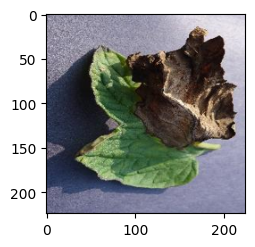

In [ ]:
import random
import matplotlib.pyplot as plt

# Number of random images to display
num_images = 20  # You can change this to any number

# Get random indices
random_indices = random.sample(range(len(x_train)), num_images)

# Create a figure and display images
plt.figure(figsize=(20, 15))  # Adjust figure size as needed

for i, index in enumerate(random_indices):
    plt.subplot(num_images // 5 + 1, 5, i + 1)  # Adjust subplot layout
    plt.imshow(x_train[index])
    plt.title(class_labels[y_train[index]])
    plt.axis("off")

plt.show()

In [ ]:
import tensorflow as tf

# resizing
resizing_and_rescaling = tf.keras.Sequential([
    tf.keras.layers.Resizing(224, 224),  # Use tf.keras.layers.Resizing directly
    tf.keras.layers.Rescaling(1.0/255)  # Use tf.keras.layers.Rescaling directly
])

In [ ]:
# Ensure TensorFlow is installed
!pip install tensorflow

import tensorflow as tf
from tensorflow.keras.layers import RandomContrast, RandomFlip, RandomRotation, RandomZoom

# Update the data_augmentation to use the correct import paths
data_augmentation = tf.keras.Sequential([
    RandomContrast(0.3),
    RandomFlip('horizontal_and_vertical'),
    RandomZoom(0.3),
    RandomRotation(0.2)
])


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization, Conv2D
from keras.applications import ResNet50V2
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Define input shape
input_shape = (224, 224, 3)

# Load the pre-trained ResNet50V2 base model
base_model = ResNet50V2(include_top=False, weights='imagenet', input_shape=input_shape)

# Freeze some layers in the base model
for layer in base_model.layers[:140]:
    layer.trainable = False

# Construct the model
model = Sequential([
    base_model,
    BatchNormalization(),
    GlobalAveragePooling2D(),  # Better at retaining spatial features
    Dense(1024, activation='relu'),
    Dropout(0.5),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(11, activation='softmax')  # Adjust the number of classes
])

# Compile the model
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    '/kaggle/input/tomato/train',  # Replace with your train dataset path
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    '/kaggle/input/tomato/valid',  # Replace with your validation dataset path
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

# Calculate class weights to handle class imbalance
class_labels = train_generator.classes
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(class_labels),
    y=class_labels
)
class_weights = dict(enumerate(class_weights))

# Callbacks
checkpoint = ModelCheckpoint(filepath='best_model.keras', save_best_only=True, monitor='val_loss', mode='min')
earlystop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1, min_lr=1e-6)
csv_logger = CSVLogger('training_log.csv')

callbacks = [checkpoint, earlystop, reduce_lr, csv_logger]

# Train the model
'''train_history = model.fit(
    train_generator,
    epochs=30,
    steps_per_epoch=200,
    validation_data=val_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_steps=val_generator.samples // val_generator.batch_size,
    class_weight=class_weights,  # Apply class weights
    callbacks=callbacks
)'''
# Train the model
'''train_history = model.fit(
    train_generator,
   # Adjust based on dataset size
    epochs=30, # You can adjust the number of epochs
    validation_data=val_generator,
    steps_per_epoch=200,
    validation_steps=100,
    class_weight=class_weights,# Adjust based on validation dataset size
    callbacks=callbacks
)'''

# ... (previous code) ...
# Train the model with EarlyStopping
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=15,
    validation_data=val_generator,  # Change valid_generator to val_generator
    validation_steps=len(val_generator),  # Change valid_generator to val_generator
    callbacks=[earlystop]  # Add the EarlyStopping callback
)

Found 25851 images belonging to 11 classes.
Found 6683 images belonging to 11 classes.
Epoch 1/15


I0000 00:00:1733466126.289755     240 service.cc:145] XLA service 0x7a03c8015220 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733466126.289813     240 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1733466126.289817     240 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


  1/808 ━━━━━━━━━━━━━━━━━━━━ 7:39:22 34s/step - accuracy: 0.0000e+00 - loss: 2.6782

I0000 00:00:1733466145.393584     240 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


808/808 ━━━━━━━━━━━━━━━━━━━━ 393s 445ms/step - accuracy: 0.4008 - loss: 1.7269 - val_accuracy: 0.8780 - val_loss: 0.3680
Epoch 2/15


AttributeError: 'NoneType' object has no attribute 'items'

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Load your test dataset
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    '/kaggle/input/tomato/valid',  # Replace with your test dataset path
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # Ensure predictions match the order of test labels
)

# Get predictions and true labels
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Compute confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Classification report
print(classification_report(true_classes, predicted_classes, target_names=class_labels))


NameError: name 'ImageDataGenerator' is not defined

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization, Conv2D, Multiply, Input, Layer
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# Define a custom Spatial Attention Layer
class SpatialAttention(Layer):
    def __init__(self, **kwargs):
        super(SpatialAttention, self).__init__(**kwargs)
        # Define the Conv2D layer here to ensure it is created only once
        self.conv = Conv2D(filters=1, kernel_size=7, strides=1, padding='same', activation='sigmoid')

    def call(self, inputs):
        avg_pool = tf.reduce_mean(inputs, axis=-1, keepdims=True)  # Average pooling
        max_pool = tf.reduce_max(inputs, axis=-1, keepdims=True)  # Max pooling
        concat = tf.concat([avg_pool, max_pool], axis=-1)  # Concatenate along the channel axis
        attention = self.conv(concat)  # Use the pre-initialized Conv2D layer
        return Multiply()([inputs, attention])  # Element-wise multiplication

# Input shape
input_shape = (224, 224, 3)

# Load the pre-trained ResNet50V2 base model
base_model = ResNet50V2(include_top=False, weights='imagenet', input_shape=input_shape)

# Freeze some layers in the base model
for layer in base_model.layers[:140]:
    layer.trainable = False

# Add Spatial Attention and fully connected layers
inputs = Input(shape=input_shape)
x = base_model(inputs, training=False)  # Ensure the base model runs in inference mode during training
x = BatchNormalization()(x)
x = SpatialAttention()(x)  # Add the custom Spatial Attention Layer
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(11, activation='softmax')(x)  # Adjust the number of classes

# Create the model
model = Model(inputs, outputs)

# Compile the model
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

# Dataset directories
train_dir = '/kaggle/input/tomato/train'
val_dir = '/kaggle/input/tomato/valid'

# Ensure the directories exist
if not os.path.exists(train_dir) or not os.path.exists(val_dir):
    raise FileNotFoundError("The dataset directories do not exist. Check your paths.")

# Load data from directories
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

# Calculate class weights to handle class imbalance
class_labels = train_generator.classes
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(class_labels),
    y=class_labels
)
class_weights = dict(enumerate(class_weights))
print(f"Class Weights: {class_weights}")

# Callbacks
checkpoint = ModelCheckpoint(filepath='best_model.keras', save_best_only=True, monitor='val_loss', mode='min')
earlystop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1, min_lr=1e-6)
csv_logger = CSVLogger('training_log.csv')

callbacks = [checkpoint, earlystop, reduce_lr, csv_logger]

# Train the model
steps_per_epoch = len(train_generator)
validation_steps = len(val_generator)

history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=15,  # Adjust the number of epochs as needed
    validation_data=val_generator,
    validation_steps=validation_steps,
    callbacks=callbacks,
    class_weight=class_weights  # Use class weights to address imbalance
)

Found 25851 images belonging to 11 classes.
Found 6683 images belonging to 11 classes.
Class Weights: {0: 0.8315962169465354, 1: 0.9572671727457878, 2: 0.7549280144847123, 3: 0.853337294513765, 4: 0.8154375118289067, 5: 1.3452151740646303, 6: 1.2863113897596656, 7: 1.152570333050961, 8: 1.0915424566144492, 9: 0.7702690623044606, 10: 2.340727997102499}
Epoch 1/15
808/808 ━━━━━━━━━━━━━━━━━━━━ 526s 620ms/step - accuracy: 0.3747 - loss: 1.7334 - val_accuracy: 0.8686 - val_loss: 0.4368 - learning_rate: 1.0000e-04
Epoch 2/15


AttributeError: 'NoneType' object has no attribute 'items'

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization, Conv2D, Flatten
from keras.applications import ResNet50V2
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
from keras.layers import Multiply
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Define the spatial attention module as a separate Layer subclass
class SpatialAttention(tf.keras.layers.Layer):
    def __init__(self, kernel_size=7, **kwargs):
        super(SpatialAttention, self).__init__(**kwargs)
        self.conv = Conv2D(1, kernel_size=kernel_size, strides=1, padding='same', activation='sigmoid')

    def call(self, input_feature):
        avg_pool = tf.reduce_mean(input_feature, axis=-1, keepdims=True)
        max_pool = tf.reduce_max(input_feature, axis=-1, keepdims=True)
        concat = tf.concat([avg_pool, max_pool], axis=-1)
        attention = self.conv(concat)
        return Multiply()([input_feature, attention])

# Define input shape
input_shape = (224, 224, 3)

# Load the pre-trained ResNet50V2 base model
base_model = ResNet50V2(include_top=False, weights='imagenet', input_shape=input_shape)

# Freeze the base model to fine-tune later
for layer in base_model.layers[:140]:  # Adjust the number based on experiment
    layer.trainable = False

# Construct the model
model = Sequential([
    base_model,
    BatchNormalization(),
    SpatialAttention(),  # Adding Spatial Attention mechanism
    GlobalAveragePooling2D(),  # Reduce spatial dimensions
    Dense(1024, activation='relu'),  # Increased layer size for better learning capacity
    Dropout(0.6),  # Increased dropout to prevent overfitting
    Dense(512, activation='relu'),
    Dropout(0.6),
    Dense(256, activation='relu'),
    Dropout(0.6),
    Dense(11, activation='softmax')  # Adjust according to your task
])

# Compile the model with Adam optimizer
optimizer = Adam(learning_rate=0.0001)  # Low learning rate for fine-tuning
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Define callbacks
checkpoint = ModelCheckpoint(filepath='best_model.keras', save_best_only=True, monitor='val_loss', mode='min')
earlystop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1, min_lr=1e-6)
csv_logger = CSVLogger('training_log.csv')

callbacks = [checkpoint, earlystop, reduce_lr, csv_logger]

# Data augmentation (important for training deep models with fewer samples)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    '/kaggle/input/tomato/train',  # Replace with your train dataset path
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    '/kaggle/input/tomato/valid',  # Replace with your validation dataset path
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

# Compute class weights
class_labels = train_generator.classes  # Class labels from the training generator
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(class_labels),
    y=class_labels
)
class_weights = dict(enumerate(class_weights))  # Convert to dictionary format for Keras
print("Class Weights:", class_weights)

'''# Train the model
train_history = model.fit(
    train_generator,
    epochs=15,  # You can adjust the number of epochs
    validation_data=val_generator,
    steps_per_epoch=len(train_generator),  # Use full training dataset size
    validation_steps=len(val_generator),  # Use full validation dataset size
    class_weight=class_weights,  # Apply class weights
    callbacks=callbacks
)'''
# Train the model
train_history = model.fit(
    train_generator,
   # Adjust based on dataset size
    epochs=20, # You can adjust the number of epochs
    validation_data=val_generator,
    steps_per_epoch=800,
    validation_steps=200,
    class_weight=class_weights,# Adjust based on validation dataset size
    callbacks=callbacks
)

Found 25851 images belonging to 11 classes.
Found 6683 images belonging to 11 classes.
Class Weights: {0: 0.8315962169465354, 1: 0.9572671727457878, 2: 0.7549280144847123, 3: 0.853337294513765, 4: 0.8154375118289067, 5: 1.3452151740646303, 6: 1.2863113897596656, 7: 1.152570333050961, 8: 1.0915424566144492, 9: 0.7702690623044606, 10: 2.340727997102499}
Epoch 1/20
800/800 ━━━━━━━━━━━━━━━━━━━━ 383s 450ms/step - accuracy: 0.1943 - loss: 2.1595 - val_accuracy: 0.8273 - val_loss: 0.5841 - learning_rate: 1.0000e-04
Epoch 2/20
800/800 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.7267 - loss: 0.8318 - val_accuracy: 0.7951 - val_loss: 0.5601 - learning_rate: 1.0000e-04
Epoch 3/20
800/800 ━━━━━━━━━━━━━━━━━━━━ 343s 426ms/step - accuracy: 0.7640 - loss: 0.7354 - val_accuracy: 0.9091 - val_loss: 0.2970 - learning_rate: 1.0000e-04
Epoch 4/20
800/800 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8399 - loss: 0.5153 - val_accuracy: 0.9364 - val_loss: 0.2513 - learning_rate: 1.0000e-04
Epoch 5/20
800

Class Distribution in Test Dataset:
Bacterial_spot: 732
Early_blight: 643
Late_blight: 792
Leaf_Mold: 739
Septoria_leaf_spot: 746
Spider_mites Two-spotted_spider_mite: 435
Target_Spot: 457
Tomato_Yellow_Leaf_Curl_Virus: 498
Tomato_mosaic_virus: 584
healthy: 805
powdery_mildew: 252


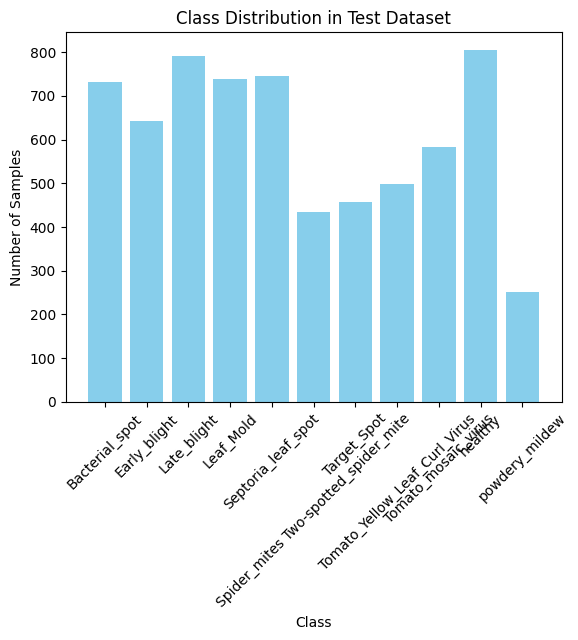

In [ ]:
# Count the number of samples per class in the test dataset
test_classes = val_generator.classes  # These are the true labels
class_labels = list(val_generator.class_indices.keys())  # Class names

# Count samples per class
import numpy as np
from collections import Counter

class_counts = Counter(test_classes)
print("Class Distribution in Test Dataset:")
for class_label, count in class_counts.items():
    print(f"{class_labels[class_label]}: {count}")

# Visualize the class distribution
import matplotlib.pyplot as plt

plt.bar(class_labels, [class_counts[i] for i in range(len(class_labels))], color='skyblue')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.title('Class Distribution in Test Dataset')
plt.xticks(rotation=45)
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Ensure that the validation data generator is reset
val_generator.reset()

# Predict the classes for the validation data
predictions = model.predict(val_generator, steps=val_generator.samples // val_generator.batch_size)

# Get the true labels from the validation generator
true_labels = val_generator.classes

# Convert the predictions to class labels (argmax)
predicted_labels = np.argmax(predictions, axis=1)

# Calculate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix using a heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=val_generator.class_indices.keys(), yticklabels=val_generator.class_indices.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


208/208 ━━━━━━━━━━━━━━━━━━━━ 23s 110ms/step


ValueError: Found input variables with inconsistent numbers of samples: [6683, 6656]

In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization, Conv2D, Flatten
from keras.applications import ResNet50V2
from keras.layers import Multiply
from sklearn.utils.class_weight import compute_class_weight
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger

# Define the spatial attention module as a separate Layer subclass
class SpatialAttention(tf.keras.layers.Layer):
    def __init__(self, kernel_size=7, **kwargs):
        super(SpatialAttention, self).__init__(**kwargs)
        self.conv = Conv2D(1, kernel_size=kernel_size, strides=1, padding='same', activation='sigmoid')

    def call(self, input_feature):
        avg_pool = tf.reduce_mean(input_feature, axis=-1, keepdims=True)
        max_pool = tf.reduce_max(input_feature, axis=-1, keepdims=True)
        concat = tf.concat([avg_pool, max_pool], axis=-1)
        attention = self.conv(concat)
        return Multiply()([input_feature, attention])

# Define input shape
input_shape = (224, 224, 3)

# Load the pre-trained ResNet50V2 base model
base_model = ResNet50V2(include_top=False, weights='imagenet', input_shape=input_shape)

# Freeze the base model to fine-tune later
for layer in base_model.layers[:140]:  # Adjust the number based on experiment
    layer.trainable = False

# Construct the model
model = Sequential([
    base_model,
    BatchNormalization(),
    SpatialAttention(),  # Adding Spatial Attention mechanism
    GlobalAveragePooling2D(),  # Reduce spatial dimensions
    Dense(1024, activation='relu'),  # Increased layer size for better learning capacity
    Dropout(0.6),  # Increased dropout to prevent overfitting
    Dense(512, activation='relu'),
    Dropout(0.6),
    Dense(256, activation='relu'),
    Dropout(0.6),
    Dense(11, activation='softmax')  # Adjust according to your task
])

# Compile the model with Adam optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)  # Low learning rate for fine-tuning
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Define callbacks
checkpoint = ModelCheckpoint(filepath='best_model.keras', save_best_only=True, monitor='val_loss', mode='min')
earlystop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1, min_lr=1e-6)
csv_logger = CSVLogger('training_log.csv')

callbacks = [checkpoint, earlystop, reduce_lr, csv_logger]

# Data augmentation (important for training deep models with fewer samples)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    '/kaggle/input/tomato/train',  # Replace with your train dataset path
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    '/kaggle/input/tomato/valid',  # Replace with your validation dataset path
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # Ensure that the labels are in the same order as the predictions
)

# Compute class weights
class_labels = train_generator.classes  # Class labels from the training generator
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(class_labels),
    y=class_labels
)
class_weights = dict(enumerate(class_weights))  # Convert to dictionary format for Keras
print("Class Weights:", class_weights)


Found 25851 images belonging to 11 classes.
Found 6683 images belonging to 11 classes.
Class Weights: {0: 0.8315962169465354, 1: 0.9572671727457878, 2: 0.7549280144847123, 3: 0.853337294513765, 4: 0.8154375118289067, 5: 1.3452151740646303, 6: 1.2863113897596656, 7: 1.152570333050961, 8: 1.0915424566144492, 9: 0.7702690623044606, 10: 2.340727997102499}


In [ ]:
train_history = model.fit(
    train_generator,
   # Adjust based on dataset size
    epochs=15, # You can adjust the number of epochs
    validation_data=val_generator,
    steps_per_epoch=800,
    validation_steps=200,
    class_weight=class_weights,# Adjust based on validation dataset size
    callbacks=callbacks
)

Epoch 1/15
800/800 ━━━━━━━━━━━━━━━━━━━━ 385s 451ms/step - accuracy: 0.2491 - loss: 2.1228 - val_accuracy: 0.7942 - val_loss: 0.6582 - learning_rate: 1.0000e-04
Epoch 2/15
800/800 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.7105 - loss: 0.9265 - val_accuracy: 0.9187 - val_loss: 0.2861 - learning_rate: 1.0000e-04
Epoch 3/15
800/800 ━━━━━━━━━━━━━━━━━━━━ 342s 424ms/step - accuracy: 0.7505 - loss: 0.7532 - val_accuracy: 0.8898 - val_loss: 0.3494 - learning_rate: 1.0000e-04
Epoch 4/15
800/800 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8047 - loss: 0.6412 - val_accuracy: 0.9753 - val_loss: 0.1063 - learning_rate: 1.0000e-04
Epoch 5/15
800/800 ━━━━━━━━━━━━━━━━━━━━ 334s 413ms/step - accuracy: 0.8805 - loss: 0.3774 - val_accuracy: 0.9231 - val_loss: 0.2680 - learning_rate: 1.0000e-04
Epoch 8/15
800/800 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9101 - loss: 0.2849 - val_accuracy: 0.9717 - val_loss: 0.1100 - learning_rate: 1.0000e-04
Epoch 9/15
800/800 ━━━━━━━━━━━━━━━━━━━━ 339s 421ms/s

209/209 ━━━━━━━━━━━━━━━━━━━━ 27s 113ms/step - accuracy: 0.9658 - loss: 0.1407
Validation Accuracy: 97.20%


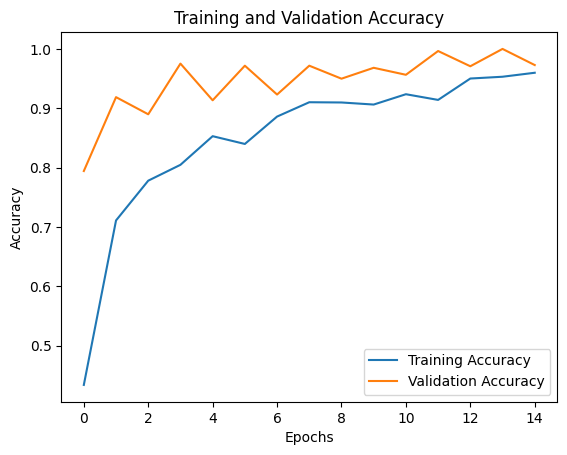

In [ ]:

loss, accuracy = loaded_model.evaluate(val_generator, steps=len(val_generator), verbose=1)

print(f"Validation Accuracy: {accuracy*100:.2f}%")

# To show accuracy during training, we can use the history object
# This is available in the `train_history` variable
train_acc = train_history.history['accuracy']
val_acc = train_history.history['val_accuracy']

# Plot the training and validation accuracy
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

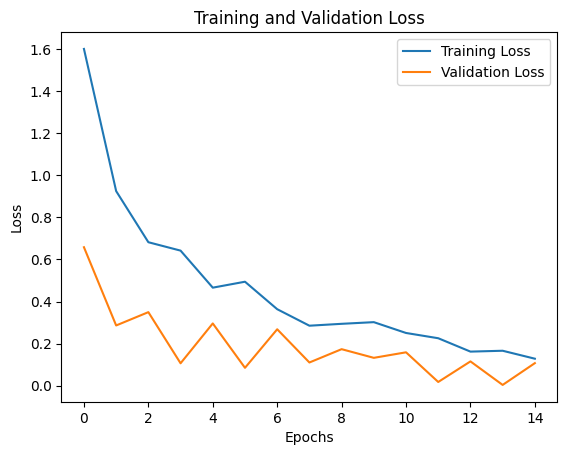

In [ ]:
train_loss = train_history.history['loss']
val_loss = train_history.history['val_loss']

plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


209/209 ━━━━━━━━━━━━━━━━━━━━ 27s 119ms/step


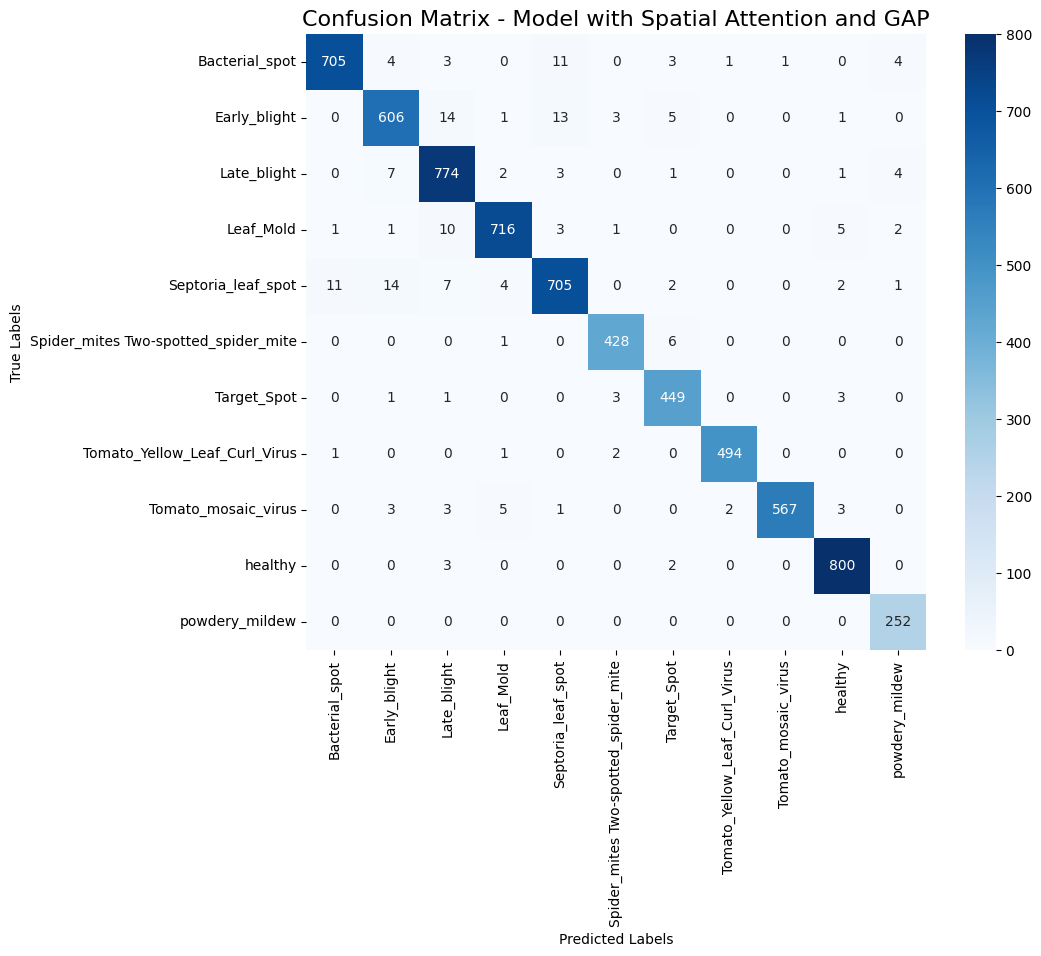

In [ ]:

# Save the trained model with spatial attention layer
model.save('model_with_spatial_attention.h5')

# Load the saved model
loaded_model = load_model('model_with_spatial_attention.h5', custom_objects={'SpatialAttention': SpatialAttention})

# Make predictions using the loaded model
predictions = loaded_model.predict(val_generator, steps=len(val_generator), verbose=1)

# Convert predictions to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Compute the confusion matrix
conf_matrix = confusion_matrix(val_generator.classes, predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=val_generator.class_indices.keys(), yticklabels=val_generator.class_indices.keys())
plt.title('Confusion Matrix - Model with Spatial Attention and GAP', fontsize=16)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

plt.show()

In [ ]:
#using flatten
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, Conv2D
from keras.applications import ResNet50V2
from keras.layers import Multiply
from sklearn.utils.class_weight import compute_class_weight
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger

# Define the spatial attention module as a separate Layer subclass
class SpatialAttention(tf.keras.layers.Layer):
    def __init__(self, kernel_size=7, **kwargs):
        super(SpatialAttention, self).__init__(**kwargs)
        self.conv = Conv2D(1, kernel_size=kernel_size, strides=1, padding='same', activation='sigmoid')

    def call(self, input_feature):
        avg_pool = tf.reduce_mean(input_feature, axis=-1, keepdims=True)
        max_pool = tf.reduce_max(input_feature, axis=-1, keepdims=True)
        concat = tf.concat([avg_pool, max_pool], axis=-1)
        attention = self.conv(concat)
        return Multiply()([input_feature, attention])

# Define input shape
input_shape = (224, 224, 3)

# Load the pre-trained ResNet50V2 base model (without the top layer)
base_model = ResNet50V2(include_top=False, weights='imagenet', input_shape=input_shape)

# Freeze the base model to fine-tune later
for layer in base_model.layers[:140]:  # Adjust the number based on experiment
    layer.trainable = False

# Construct the model
model = Sequential([
    base_model,
    BatchNormalization(),
    SpatialAttention(),  # Adding Spatial Attention mechanism
    Flatten(),  # Flattening the feature maps (instead of GAP)
    Dense(1024, activation='relu'),  # Increased layer size for better learning capacity
    Dropout(0.6),  # Increased dropout to prevent overfitting
    Dense(512, activation='relu'),
    Dropout(0.6),
    Dense(256, activation='relu'),
    Dropout(0.6),
    Dense(11, activation='softmax')  # Adjust according to your task (number of classes)
])

# Compile the model with Adam optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)  # Low learning rate for fine-tuning
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Define callbacks
checkpoint = ModelCheckpoint(filepath='best_model.keras', save_best_only=True, monitor='val_loss', mode='min')
earlystop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1, min_lr=1e-6)
csv_logger = CSVLogger('training_log.csv')

callbacks = [checkpoint, earlystop, reduce_lr, csv_logger]

# Data augmentation (important for training deep models with fewer samples)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    '/kaggle/input/tomato/train',  # Replace with your train dataset path
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    '/kaggle/input/tomato/valid',  # Replace with your validation dataset path
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # Ensure that the labels are in the same order as the predictions
)

# Compute class weights
class_labels = train_generator.classes  # Class labels from the training generator
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(class_labels),
    y=class_labels
)
class_weights = dict(enumerate(class_weights))  # Convert to dictionary format for Keras
print("Class Weights:", class_weights)

Found 25851 images belonging to 11 classes.
Found 6683 images belonging to 11 classes.
Class Weights: {0: 0.8315962169465354, 1: 0.9572671727457878, 2: 0.7549280144847123, 3: 0.853337294513765, 4: 0.8154375118289067, 5: 1.3452151740646303, 6: 1.2863113897596656, 7: 1.152570333050961, 8: 1.0915424566144492, 9: 0.7702690623044606, 10: 2.340727997102499}


In [ ]:
train_history = model.fit(
    train_generator,
   # Adjust based on dataset size
    epochs=15, # You can adjust the number of epochs
    validation_data=val_generator,
    steps_per_epoch=800,
    validation_steps=200,
    class_weight=class_weights,# Adjust based on validation dataset size
    callbacks=callbacks
)

Epoch 1/15
800/800 ━━━━━━━━━━━━━━━━━━━━ 794s 954ms/step - accuracy: 0.1114 - loss: 2.3642 - val_accuracy: 0.1714 - val_loss: 2.2786 - learning_rate: 1.0000e-04
Epoch 2/15
800/800 ━━━━━━━━━━━━━━━━━━━━ 17s 21ms/step - accuracy: 0.1951 - loss: 2.1938 - val_accuracy: 0.8410 - val_loss: 0.6146 - learning_rate: 1.0000e-04
Epoch 3/15
800/800 ━━━━━━━━━━━━━━━━━━━━ 777s 964ms/step - accuracy: 0.2281 - loss: 2.0711 - val_accuracy: 0.4347 - val_loss: 1.7001 - learning_rate: 1.0000e-04
Epoch 4/15
800/800 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4256 - loss: 1.6057 - val_accuracy: 0.8127 - val_loss: 0.7427 - learning_rate: 1.0000e-04
Epoch 5/15
800/800 ━━━━━━━━━━━━━━━━━━━━ 346s 429ms/step - accuracy: 0.4272 - loss: 1.5431 - val_accuracy: 0.7223 - val_loss: 0.9418 - learning_rate: 1.0000e-04
Epoch 6/15
800/800 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.6324 - loss: 1.0570 - val_accuracy: 0.9364 - val_loss: 0.3071 - learning_rate: 1.0000e-04
Epoch 7/15
800/800 ━━━━━━━━━━━━━━━━━━━━ 455s 564

209/209 ━━━━━━━━━━━━━━━━━━━━ 26s 126ms/step - accuracy: 0.8381 - loss: 0.5467
Validation Accuracy: 86.40%


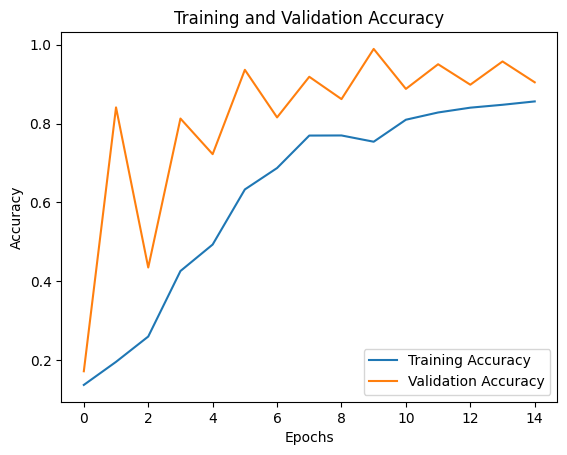

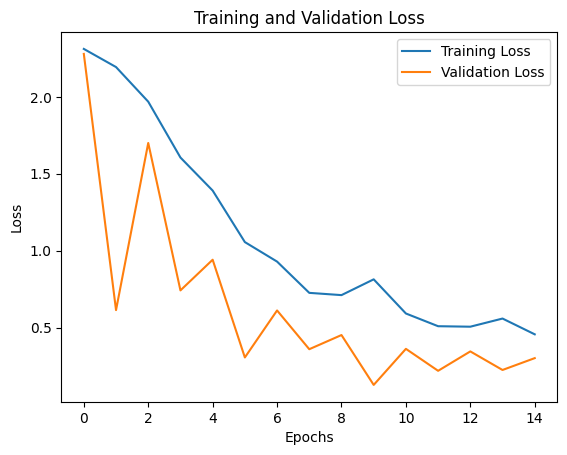

In [ ]:
# Evaluate the model accuracy
loss, accuracy = loaded_model.evaluate(val_generator, steps=len(val_generator), verbose=1)

print(f"Validation Accuracy: {accuracy*100:.2f}%")


# To show accuracy during training, we can use the history object
# This is available in the `train_history` variable
train_acc = train_history.history['accuracy']

val_acc = train_history.history['val_accuracy']

# Plot the training and validation accuracy
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot the training and validation loss
train_loss = train_history.history['loss']
val_loss = train_history.history['val_loss']

plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

209/209 ━━━━━━━━━━━━━━━━━━━━ 67s 307ms/step


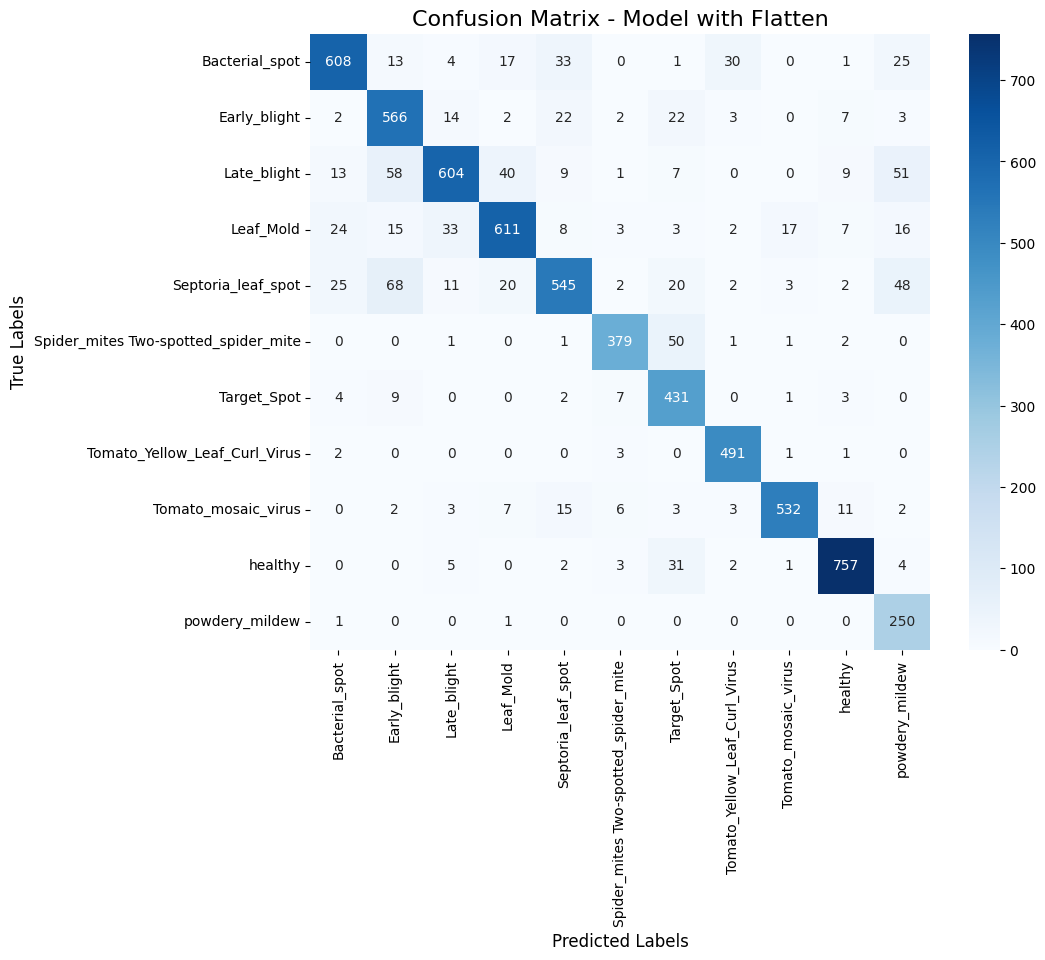

In [ ]:
# Save the trained model with spatial attention layer and Flatten
model.save('model_with_spatial_attention_and_flatten.h5')

# Load the saved model
loaded_model = load_model('model_with_spatial_attention_and_flatten.h5', custom_objects={'SpatialAttention': SpatialAttention})
predictions = loaded_model.predict(val_generator, steps=len(val_generator), verbose=1)

# Convert predictions to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Compute the confusion matrix
conf_matrix = confusion_matrix(val_generator.classes, predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=val_generator.class_indices.keys(), yticklabels=val_generator.class_indices.keys())
plt.title('Confusion Matrix - Model with Flatten', fontsize=16)
plt.xlabel('Predicted Labels', fontsize=12)
plt.ylabel('True Labels', fontsize=12)



plt.show()